# Mounting google drive : 
The trained model weights will be saved here.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Train and test data loaders

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import torch
import torchvision
from torchvision import transforms
from data_loader import get_train_test_data_loaders
batch_size = 512
train_loader, test_loader, classes = get_train_test_data_loaders(random_seed=1,batch_size =batch_size)

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


 deer   car horse   dog


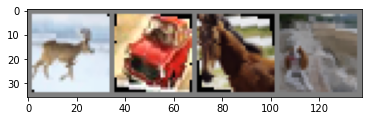

In [5]:
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
from model import CIFARClassifier
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("device: ",device)
model = CIFARClassifier().to(device)

device:  cuda


In [7]:
from torchsummary import summary
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]             288
            Conv2d-9           [-1, 64, 16, 16]           2,048
  SeparableConv2d-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]             576
           Conv2d-14           [-1, 64,

In [8]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from cifar10_trainer import ModelTrainer
import torch.nn.functional as F

root_path = r"/content/gdrive/MyDrive/EVA5/S7AssignmentSolution"

EPOCHS = 100
train_test_history ={}

model = CIFARClassifier().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
model_trainer = ModelTrainer()
  
for epoch in range(EPOCHS):
  print("EPOCH:", epoch)
  model_trainer.train(model, device, train_loader, optimizer, epoch, l1_penalty=0)
  scheduler.step()
  model_trainer.test(model, device, test_loader)

train_test_history[epoch] = {
    "train_losses": model_trainer.train_losses,
    "test_losses": model_trainer.test_losses,
    "train_accuracies": model_trainer.train_acc,
    "test_accuracies": model_trainer.test_acc
}
model_file_name = f"cifar_10_epoch_{EPOCHS}.pth"
model_path =f"{root_path}/{model_file_name}"
torch.save(model.state_dict(), model_path)
print(f"Saving the model for at {model_path}.")

EPOCH: 0
Train set: Average loss: 0.0037, Accuracy: 14542/50000 (29.08%)
Test set: Average loss: 1.5747, Accuracy: 4127/10000 (41.27%)
EPOCH: 1
Train set: Average loss: 0.0030, Accuracy: 22004/50000 (44.01%)
Test set: Average loss: 1.3923, Accuracy: 4924/10000 (49.24%)
EPOCH: 2
Train set: Average loss: 0.0026, Accuracy: 25384/50000 (50.77%)
Test set: Average loss: 1.3886, Accuracy: 4919/10000 (49.19%)
EPOCH: 3
Train set: Average loss: 0.0024, Accuracy: 27617/50000 (55.23%)
Test set: Average loss: 1.1388, Accuracy: 5810/10000 (58.10%)
EPOCH: 4
Train set: Average loss: 0.0023, Accuracy: 29157/50000 (58.31%)
Test set: Average loss: 1.0738, Accuracy: 6079/10000 (60.79%)
EPOCH: 5
Train set: Average loss: 0.0021, Accuracy: 30444/50000 (60.89%)
Test set: Average loss: 1.1191, Accuracy: 6032/10000 (60.32%)
EPOCH: 6
Train set: Average loss: 0.0020, Accuracy: 31320/50000 (62.64%)
Test set: Average loss: 1.0296, Accuracy: 6396/10000 (63.96%)
EPOCH: 7
Train set: Average loss: 0.0020, Accuracy: 319

In [ ]:
import json

with open(f"{root_path}/train_test_metrics.json", "w") as outfile:  
    json.dump(train_test_history, outfile)

GroundTruth:    cat  ship  ship plane


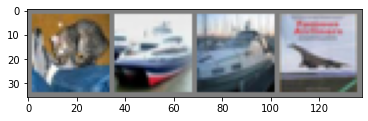

In [12]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
# images, labels = images.to(device), labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images[0:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [14]:
train_test_history.keys()

dict_keys([99])

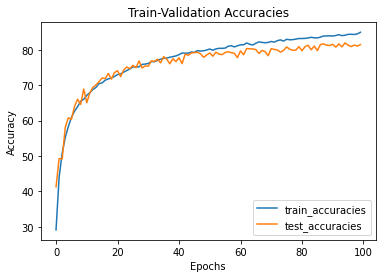

In [16]:
fig, ax = plt.subplots()
ax.plot(train_test_history[99]["train_accuracies"],label="train_accuracies")
ax.plot(train_test_history[99]["test_accuracies"],label="test_accuracies")
leg = ax.legend()
  
plt.title('Train-Validation Accuracies')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig(f'{root_path}/accuracy_plot.png')